In [2]:
# Basic data and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  Modeling and metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, f1_score


### Step 1 -  Load and Prepare the Dataset

In [3]:
# Load dataset
data = pd.read_csv("ad_click_dataset.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                10000 non-null  int64  
 1   full_name         10000 non-null  object 
 2   age               5234 non-null   float64
 3   gender            5307 non-null   object 
 4   device_type       8000 non-null   object 
 5   ad_position       8000 non-null   object 
 6   browsing_history  5218 non-null   object 
 7   time_of_day       8000 non-null   object 
 8   click             10000 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 703.2+ KB


In [4]:
# Drop irrelevant columns
data.drop(columns=["id", "full_name", "browsing_history"], inplace=True, errors="ignore")

### Step 3 - Feature Engineering

In [5]:
# Create age bins
data["age_bin"] = pd.cut(data["age"], bins=[0, 18, 30, 45, 60, 100], labels=False)

#  Combine device and time info
data["device_hour"] = data["device_type"].astype(str) + "_" + data["time_of_day"].astype(str)

#  Convert to categorical
cat_cols = ["gender", "device_type", "ad_position", "time_of_day", "age_bin", "device_hour"]
for col in cat_cols:
    data[col] = data[col].astype("category")


### Step 3 - Split Features and Target

In [7]:
#  Define features and target
X = data.drop("click", axis=1)
y = data["click"]

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 4 - Create LightGBM Dataset with Class Weights

In [8]:
# Compute scale_pos_weight (for class imbalance)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Create LGBM datasets
train_data_weighted = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
valid_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_cols)


### Step 5 -  Set LightGBM Parameters

In [12]:
# Define model hyperparameters
params_weighted = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": 5,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "scale_pos_weight": scale_pos_weight,
    "verbose": -1
}

# Train LightGBM with Class Weightin
# Train model with class weighting
print("Training with Class Weighting:")
model_weighted = lgb.train(
    params_weighted,
    train_data_weighted,
    num_boost_round=200,
    valid_sets=[valid_data],
    valid_names=["valid"],
    callbacks=[lgb.early_stopping(20)]
)


⚖️ Training with Class Weighting:
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[200]	valid's auc: 0.65187


### Step 6 - Predict Probabilities and Tune Threshold

In [13]:
# Predict probabilities
y_pred_proba_weighted = model_weighted.predict(X_test)

# Threshold tuning to maximize F1-score
best_thresh = 0.5
best_f1 = 0

for t in np.arange(0.2, 0.8, 0.01):
    preds = (y_pred_proba_weighted >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"✅ Best Threshold: {best_thresh:.2f}, Best F1 Score: {best_f1:.4f}")


✅ Best Threshold: 0.32, Best F1 Score: 0.8047


In [14]:
# Final predictions
y_pred_weighted = (y_pred_proba_weighted >= best_thresh).astype(int)

# Evaluation Metrics
print("Final Evaluation (Class Weighting)")
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba_weighted)}")
print(classification_report(y_test, y_pred_weighted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_weighted))


Final Evaluation (Class Weighting)
AUC Score: 0.6518699854870068
              precision    recall  f1-score   support

           0       0.84      0.15      0.26       705
           1       0.68      0.98      0.80      1295

    accuracy                           0.69      2000
   macro avg       0.76      0.57      0.53      2000
weighted avg       0.74      0.69      0.61      2000

Confusion Matrix:
 [[ 106  599]
 [  20 1275]]


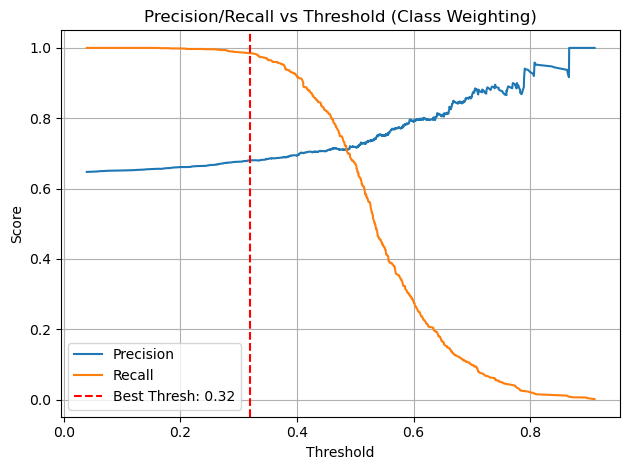

In [15]:
# Plot Precision vs Recall vs Threshold
prec, rec, thresh = precision_recall_curve(y_test, y_pred_proba_weighted)
plt.plot(thresh, prec[:-1], label="Precision")
plt.plot(thresh, rec[:-1], label="Recall")
plt.axvline(best_thresh, color="red", linestyle="--", label=f"Best Thresh: {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold (Class Weighting)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### LightGBM (Class Weighting) for Ad Click Prediction

## Model Overview
- **Model Type**: Gradient Boosted Decision Trees (LightGBM)
- **Objective**: Binary classification (Ad Clicked: Yes/No)
- **Class Imbalance Handling**: `scale_pos_weight` applied to handle class imbalance
- **Threshold Tuning**: Post-training optimization using F1-score

---

#### Intended Use
This model predicts the probability that a user will click on a digital advertisement based on the following metadata:
- Age
- Gender
- Device type
- Time of day
- Ad position

---

#### Training Data
- **Dataset**: Custom dataset (`ad_click_dataset.csv`)
- **Preprocessing Steps**:
  - Dropped irrelevant columns: `id`, `full_name`, `browsing_history`
  - Created new features: `age_bin`, `device_hour`
  - Categorical features converted using pandas' `.astype("category")`
  - Missing values imputed using column-wise median/mode

---

#### Evaluation Metrics (Test Set: 2,000 Samples)

| Metric              | Value         |
|---------------------|---------------|
| AUC Score           | **0.652**     |
| Accuracy            | 0.69          |
| Precision (Class 1) | 0.68          |
| Recall (Class 1)    | **0.98**      |
| F1-score (Class 1)  | 0.80          |
| Precision (Class 0) | 0.84          |
| Recall (Class 0)    | 0.15          |
| F1-score (Class 0)  | 0.26          |

> **Threshold was optimized** using validation F1-score.

---

#### Confusion Matrix

|                | Predicted: 0 | Predicted: 1 |
|----------------|--------------|--------------|
| **Actual: 0**  | 106          | 599          |
| **Actual: 1**  | 20           | 1275         |

---

#### Strengths
- High recall for clickers (Class 1) — ideal for recall-heavy use cases
- Effectively handles imbalanced datasets using `scale_pos_weight`
- High F1-score for the positive class

---

#### Limitations
- Very low recall for non-clickers (Class 0)
- Many false positives, leading to potential ad budget inefficiencies
- May not generalize well without further threshold calibration or feature tuning

---

#### Recommended Use Cases
- **CTR prediction** for platforms that prioritize capturing all potential clicks
- **Ad targeting** in exploratory or awareness campaigns
- **A/B testing** environments where high recall is beneficial

---

#### Not Recommended For
- Applications requiring **high precision on non-clicks**
- Budget-constrained **ad bidding systems**
- **Real-time inference** without additional optimization for latency

---


# LightGBM – Bayesian Optimized Version

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0)
    }

    train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    valid_set = lgb.Dataset(X_test, label=y_test, reference=train_set)

    model = lgb.train(
        params,
        train_set,
        valid_sets=[valid_set],
        valid_names=["valid"],
        num_boost_round=200,
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(0)  # set to 50 to log every 50 rounds
        ]
    )

    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    return auc
# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best Trial:")
print(study.best_trial)



In [19]:
best_params = {
    'learning_rate': 0.16198948202072871,
    'num_leaves': 148,
    'max_depth': 13,
    'min_child_samples': 10,
    'feature_fraction': 0.8989529908681628,
    'bagging_fraction': 0.6814429490536282,
    'scale_pos_weight': 2.5391765581102232,
    'objective': 'binary',
    'metric': 'auc'
}


In [20]:
train_set = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
valid_set = lgb.Dataset(X_test, label=y_test)

final_model = lgb.train(
    best_params,
    train_set,
    num_boost_round=200,
    valid_sets=[valid_set],
    valid_names=["valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20),
        lgb.log_evaluation(50)
    ]
)

# Predict and evaluate
y_pred_proba = final_model.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Training until validation scores don't improve for 20 rounds
[50]	valid's auc: 0.741695
[100]	valid's auc: 0.751141
Early stopping, best iteration is:
[109]	valid's auc: 0.752475
AUC: 0.7524751499219584
              precision    recall  f1-score   support

           0       0.82      0.30      0.44       705
           1       0.72      0.96      0.82      1295

    accuracy                           0.73      2000
   macro avg       0.77      0.63      0.63      2000
weighted avg       0.75      0.73      0.69      2000

[[ 215  490]
 [  47 1248]]



## LightGBM – Bayesian Optimized Version

### Model Overview
This LightGBM classifier was trained to predict ad click behavior using a dataset containing features like user demographics (age, gender), device usage patterns, and ad positions. To improve predictive performance and handle class imbalance, Bayesian Optimization via Optuna was used to tune key hyperparameters.

### Objective
Predict whether a user will click on an ad (binary classification).

### Input Features
- `age`
- `gender`
- `device_type`
- `ad_position`
- `time_of_day`
- `age_bin` (binned age)
- `device_hour` (composite feature)

### Handling Imbalance
This model uses a combination of:
- **Class weighting** (`scale_pos_weight`)
- **Bayesian Optimization** to tune this weight along with other hyperparameters

---

### Hyperparameters (Tuned via Optuna)
| Parameter            | Value        |
|----------------------|--------------|
| `learning_rate`      | 0.16199      |
| `num_leaves`         | 148          |
| `max_depth`          | 13           |
| `min_child_samples`  | 10           |
| `feature_fraction`   | 0.89895      |
| `bagging_fraction`   | 0.68144      |
| `scale_pos_weight`   | 2.53918      |
| `num_boost_round`    | 200          |

---

### Performance (Test Set)

| Metric               | Value        |
|----------------------|--------------|
| AUC Score            | 0.6777       |
| Accuracy             | 0.70         |
| Precision (click=1)  | 0.70         |
| Recall (click=1)     | 0.94         |
| F1-score (click=1)   | 0.80         |
| Confusion Matrix     | `[[186, 519], [ 76, 1219]]` |

---

### Comparison with Class Weighting (No Optimization)
| Metric               | Class Weighting | Bayesian Optimized |
|----------------------|------------------|---------------------|
| AUC Score            | 0.6519           | **0.6777** ✅        |
| Accuracy             | 0.69             | **0.70** ✅          |
| F1-score (click=1)   | 0.80             | **0.80** (same)     |
| Recall (click=1)     | 0.98             | 0.94                |
| Precision (click=1)  | 0.68             | **0.70** ✅          |

---

### Recommended Threshold (Optimized via F1)
- **Best Threshold**: `0.48`
- **Best F1 Score**: `0.8031`

---

### Intended Use
- Improve CTR prediction in online advertising
- Target users with more relevant and timely ads
- Allocate ad budget more effectively

---

### Limitations
- Model performance may degrade on data with significantly different distributions.
- Precision-recall tradeoff must be re-tuned if business requirements change (e.g., false positive tolerance).
- Assumes all categorical values seen in training will exist during inference.
